In [202]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import pearsonr, spearmanr

# Arial font
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

import statsmodels.formula.api as smf

float_format = lambda x: '%.3f' % x
# Set dataframe print precision to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

show_stats = [
    'player', 'Tm', 'agg_score', 'insta_mentions', 
    'G', 'PTS', 'TRB', 'AST', 'BLK', 'STL', 'TOV'
]

# Define any additional metrics to add to the stats df, e.g. fantasy points
def add_metrics(df):
    df['agg_score'] = 1*df['PTS'] + 1.2*df['TRB'] + 1.5*df['AST'] + 2*df['BLK'] + 2*df['STL'] - 1*df['TOV']
    df['any_mentions'] = (df['insta_mentions'] > 0).astype(int)
    df['log2_mentions'] = np.log2(df['insta_mentions'])
    return df

In [169]:
path = './data/202324_instagram_counts_and_stats.csv'
df = pd.read_csv(path, index_col=0, dtype={'G': int}).reset_index()
df = add_metrics(df)
display(df.head(10))

/Users/rajivmovva/miniconda3/envs/llm/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,player,insta_mentions,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV,agg_score,any_mentions,log2_mentions
0,A.J. Green,0,MIL,19,7.70,3.20,0.80,0.70,0.00,0.00,0.44,0.62,0.00,5.21,0,-inf
1,A.J. Lawson,0,DAL,11,8.30,3.50,0.70,0.40,0.40,0.10,0.47,0.53,0.50,5.44,0,-inf
2,AJ Griffin,0,ATL,12,9.20,2.50,1.00,0.30,0.10,0.00,0.29,0.41,0.30,4.05,0,-inf
3,Aaron Gordon,9,DEN,26,32.00,13.50,6.90,3.50,1.00,0.60,0.52,0.54,1.40,28.83,1,3.17
4,Aaron Holiday,1,HOU,24,18.10,7.00,1.90,1.70,0.50,0.10,0.45,0.57,0.60,12.43,1,0.00
5,Aaron Nesmith,2,IND,25,24.70,11.90,3.10,1.00,1.00,0.80,0.54,0.67,0.70,20.02,1,1.00
6,Aaron Wiggins,0,OKC,24,12.40,5.20,2.20,0.70,0.50,0.00,0.59,0.67,0.50,9.39,0,-inf
7,Admiral Schofield,0,ORL,8,3.50,0.90,0.60,0.30,0.00,0.00,0.30,0.35,0.50,1.57,0,-inf
8,Al Horford,3,BOS,23,26.70,7.70,7.10,2.80,0.40,1.00,0.47,0.58,1.00,22.22,1,1.58
9,Alec Burks,0,DET,21,17.50,9.00,2.10,1.40,0.40,0.20,0.33,0.43,0.40,14.42,0,-inf


### start simple: are there players with very similar stats who receive different amounts of attention?

In [381]:
# display(df[(df['agg_score'] > 26) & (df['agg_score'] < 28)][show_stats].sort_values(by='insta_mentions', ascending=False))
# display(df[(df['agg_score'] > 30) & (df['agg_score'] < 33)][show_stats].sort_values(by='insta_mentions', ascending=False))
# display(df[(df['agg_score'] > 39) & (df['agg_score'] < 41)][show_stats].sort_values(by='insta_mentions', ascending=False))
# display(df[(df['agg_score'] > 41) & (df['agg_score'] < 43)][show_stats].sort_values(by='insta_mentions', ascending=False))
display(df[(df['agg_score'] > 45)][show_stats].sort_values(by='insta_mentions', ascending=False))

,player,Tm,agg_score,insta_mentions,G,PTS,TRB,AST,BLK,STL,TOV
326,LeBron James,LAL,46.39,160,26,25.20,7.70,7.30,0.70,1.50,3.40
166,Giannis Antetokounmpo,MIL,53.50,74,27,30.90,11.00,5.40,1.20,1.40,3.90
301,Kevin Durant,PHO,46.74,74,24,30.90,6.20,5.40,1.10,0.80,3.50
489,Tyrese Haliburton,IND,47.10,70,24,24.30,4.00,12.00,0.60,0.80,2.80
334,Luka Doncic,DAL,56.03,64,26,32.70,8.40,9.10,0.50,1.30,4.00
388,Nikola Jokic,DEN,56.66,55,29,26.70,12.30,9.20,0.80,1.20,2.60
253,Joel Embiid,PHI,60.64,48,25,35.00,11.70,6.00,2.00,1.20,3.80
449,Shai Gilgeous-Alexander,OKC,52.31,44,25,30.70,5.80,6.30,0.80,2.80,2.00
476,Trae Young,ATL,47.40,34,26,28.30,3.00,11.20,0.20,1.30,4.30
130,Devin Booker,PHO,45.70,33,19,27.70,5.50,8.20,0.40,0.60,2.90


#### Screenshot for post

In [394]:
sub_df = df[(df['agg_score'] > 26.79) & (df['agg_score'] < 28)][show_stats].sort_values(by='insta_mentions', ascending=False).copy()

print_cols = ['player', 'Tm', 'agg_score', 'insta_mentions']
sub_df = sub_df[print_cols].copy().reset_index(drop=True)
sub_df['agg_score'] = sub_df['agg_score'].apply(lambda x: '%.1f' % x)
sub_df = sub_df.rename(columns={'agg_score': 'Fantasy PPG', 
                                'insta_mentions': '# Instagram Mentions',
                                'Tm': 'Team',
                                'player': 'Name'
                                })
# Title the dataframe: Players with ~27 fantasy PPG
sub_df = sub_df.style.set_caption('Players with ~27 fantasy PPG')
display(sub_df)

,Name,Team,Fantasy PPG,# Instagram Mentions
0,Austin Reaves,LAL,28.0,23
1,Russell Westbrook,LAC,26.8,19
2,Jalen Green,HOU,27.1,11
3,Keegan Murray,SAC,27.0,11
4,Shaedon Sharpe,POR,27.9,7
5,John Collins,UTA,27.1,4
6,Brook Lopez,MIL,28.0,3
7,Jordan Clarkson,UTA,27.0,3
8,Max Strus,CLE,27.0,2
9,Daniel Gafford,WAS,27.2,1


## Regressions

### who is above/below a best fit line?

In [395]:
df_above_thresh = df.copy()
t = 5
df_above_thresh = df_above_thresh[df_above_thresh['insta_mentions'] >= t]
df_above_thresh = df_above_thresh[df_above_thresh['G'] >= 10]

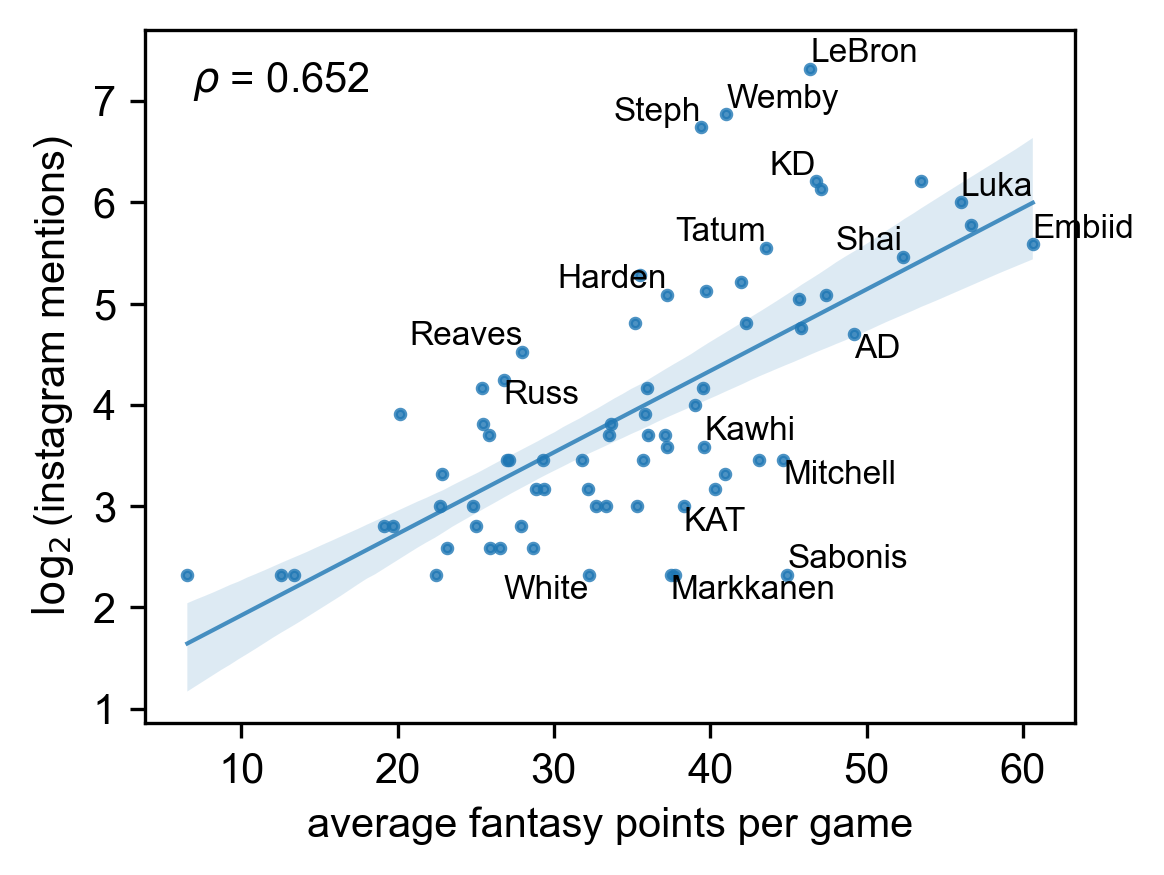

In [400]:
# Do an sns.regplot of np.log2(insta_mentions) against agg_score
import seaborn as sns
plt.figure(figsize=(4,3), dpi=300)

x_col = 'agg_score'
y_col = 'log2_mentions'

sns.regplot(x=x_col, y=y_col, 
            data=df_above_thresh, scatter_kws={'s': 5, 'alpha': 0.8,},
            order=1,
            line_kws={'alpha': 0.8, 'lw': 1}
            )

# Annotate the plot with R^2 in top-left
r = spearmanr(df_above_thresh[x_col], df_above_thresh[y_col])[0]
# plt.text(0.05, 0.91, r'$R^2$ = ' + float_format(r*r), transform=plt.gca().transAxes)
plt.text(0.05, 0.91, r'$\rho$ = ' + float_format(r), transform=plt.gca().transAxes)

plt.xlabel('average fantasy points per game')
plt.ylabel(r'$\log_2$(instagram mentions)')

# Set ylim slightly higher
ymin, ymax = plt.ylim()
plt.ylim(ymin, ymax*1.01)

# Annotate players who are in the top K of either stat
annot_players = {
    'LeBron James': ('LeBron', 'left', 'bottom'),
    'Kevin Durant': ('KD', 'right', 'bottom'),
    'Stephen Curry': ('Steph', 'right', 'bottom'),
    'James Harden': ('Harden', 'right', 'bottom'),
    'Russell Westbrook': ('Russ', 'left', 'top'),
    # 'Giannis Antetokounmpo': ('Giannis', 'right', 'bottom'),
    'Anthony Davis': ('AD', 'left', 'top'),
    'Kawhi Leonard': ('Kawhi', 'left', 'bottom'),
    # 'Damian Lillard': ('Dame', 'left', 'bottom'),
    'Joel Embiid': ('Embiid', 'left', 'bottom'),
    'Luka Doncic': ('Luka', 'left', 'bottom'),
    'Victor Wembanyama': ('Wemby', 'left', 'bottom'),
    'Shai Gilgeous-Alexander': ('Shai', 'right', 'bottom'),
    'Jayson Tatum': ('Tatum', 'right', 'bottom'),
    # # 'Devin Booker': ('Booker', 'left', 'bottom'),
    # 'Jaylen Brown': ('Jaylen Brown', 'right', 'bottom'),
    # 'Chet Holmgren': ('Chet Holmgren', 'right', 'bottom'),
    # # 'Jalen Green': ('Jalen Green', 'left', 'bottom'),
    # 'Trae Young': ('Trae Young', 'left', 'bottom'), 
    # 'Zion Williamson': ('Zion', 'right', 'bottom'),
    # 'Nikola Jokic': ('Jokic', 'left', 'bottom'),
    'Austin Reaves': ('Reaves', 'right', 'bottom'),
    # 'Tyrese Haliburton': ('Haliburton', 'right', 'top'),
    # # 'Anthony Edwards': ('Ant', 'left', 'bottom'),
    # "De'Aaron Fox": ('Fox', 'left', 'bottom'),
    # 'Klay Thompson': ('Klay', 'left', 'bottom'), 
    # 'Obi Toppin': ('Obi Toppin', 'right', 'bottom'),
    'Donovan Mitchell': ('Mitchell', 'left', 'top'),
    # 'Ja Morant': ('Morant', 'left', 'top'),
    # # 'Bam Adebayo': ('Adebayo', 'right', 'bottom'),
    'Derrick White': ('White', 'right', 'top'),
    # 'Julius Randle': ('Randle', 'left', 'top'),
    'Domantas Sabonis': ('Sabonis', 'left', 'bottom'),
    # 'Jamal Murray': ('Murray', 'left', 'bottom'),
    # 'Jalen Brunson': ('Brunson', 'left', 'top'),
    # 'Alperen Sengun': ('Sengun', 'left', 'bottom'),
    'Karl-Anthony Towns': ('KAT', 'left', 'top'),
    # # 'Paolo Banchero': ('Banchero', 'left', 'bottom'),
    # # 'Paul George': ('PG', 'right', 'top'),
    'Lauri Markkanen': ('Markkanen', 'left', 'top'),
}
for player, (annot, ha, va) in annot_players.items():
    player_row = df_above_thresh[df_above_thresh['player'] == player]
    try:
        x = player_row[x_col].values[0]
        y = player_row[y_col].values[0]
        plt.annotate(annot, (x, y), ha=ha, va=va, fontsize=8)
    except IndexError:
        print(f'{player} not found in df_above_thresh')

# for player in df_above_thresh.player.values:
#     player_row = df_above_thresh[df_above_thresh['player'] == player]
#     x = player_row[x_col].values[0]
#     y = player_row[y_col].values[0]
#     plt.annotate(player, (x, y), ha='center', va='center', fontsize=4)

plt.savefig('./smallregplot.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()

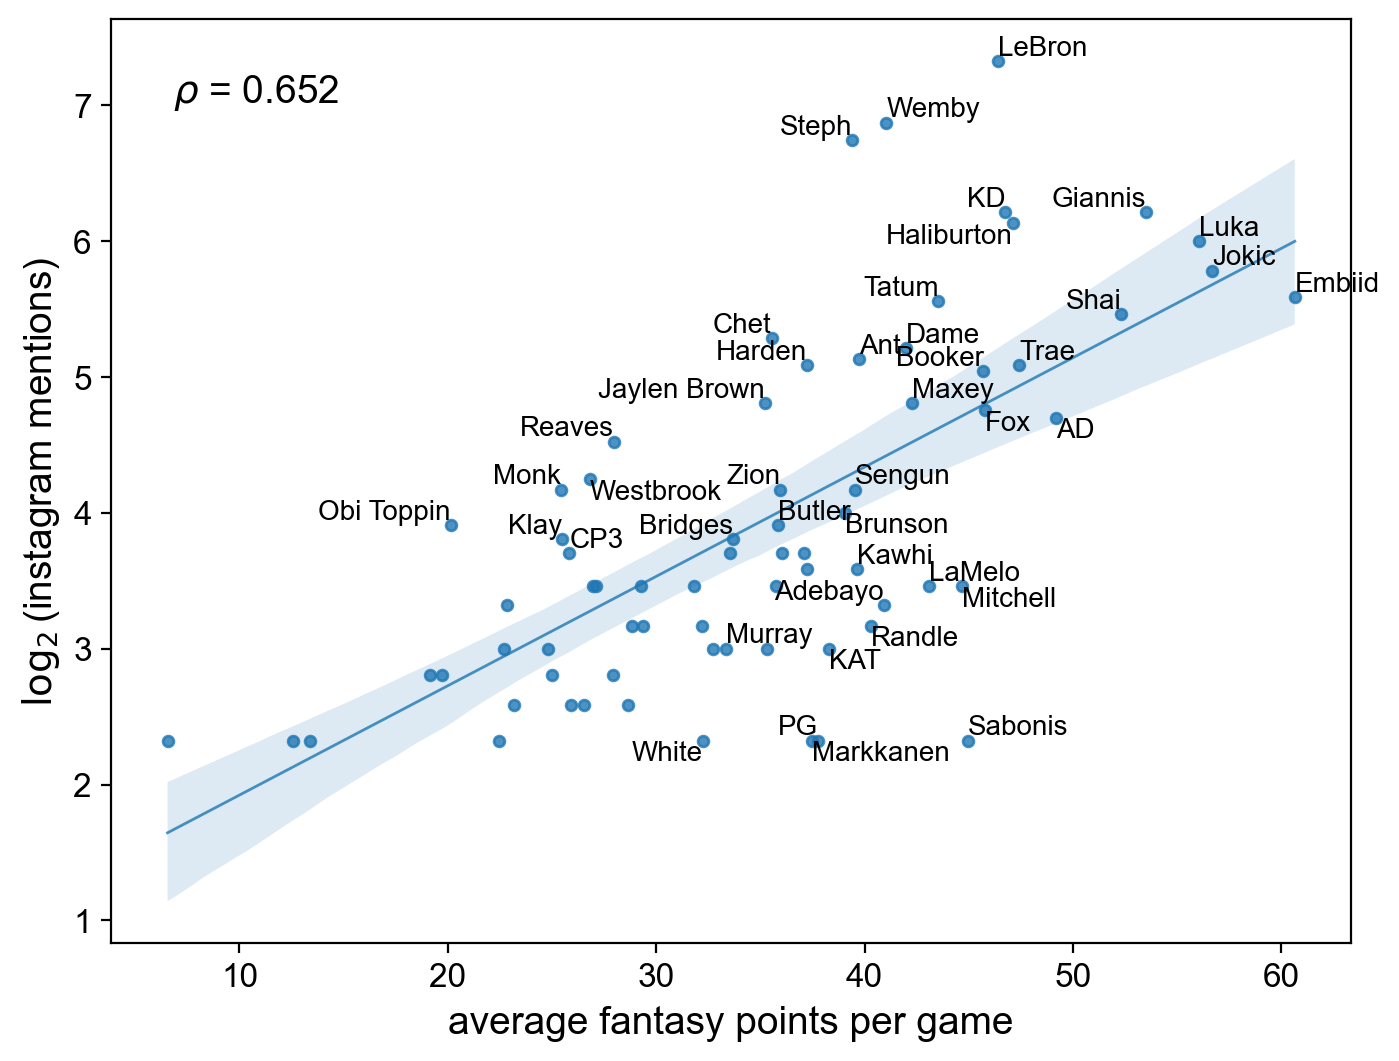

In [414]:
# Do an sns.regplot of np.log2(insta_mentions) against agg_score
import seaborn as sns
plt.figure(figsize=(8,6), dpi=200)

x_col = 'agg_score'
y_col = 'log2_mentions'

sns.regplot(x=x_col, y=y_col, 
            data=df_above_thresh, scatter_kws={'s': 15, 'alpha': 0.8,},
            order=1,
            line_kws={'alpha': 0.8, 'lw': 1}
            )

# Annotate the plot with R^2 in top-left
r = spearmanr(df_above_thresh[x_col], df_above_thresh[y_col])[0]
plt.text(0.05, 0.91, r'$\rho$ = ' + float_format(r), transform=plt.gca().transAxes, fontsize=14)

plt.xlabel('average fantasy points per game', fontsize=14)
plt.ylabel(r'$\log_2$(instagram mentions)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate players who are in the top K of either stat
annot_players = {
    'LeBron James': ('LeBron', 'left', 'bottom'),
    'Kevin Durant': ('KD', 'right', 'bottom'),
    'Stephen Curry': ('Steph', 'right', 'bottom'),
    'James Harden': ('Harden', 'right', 'bottom'),
    'Russell Westbrook': ('Westbrook', 'left', 'top'),
    'Giannis Antetokounmpo': ('Giannis', 'right', 'bottom'),
    'Anthony Davis': ('AD', 'left', 'top'),
    'Kawhi Leonard': ('Kawhi', 'left', 'bottom'),
    'Damian Lillard': ('Dame', 'left', 'bottom'),
    'Joel Embiid': ('Embiid', 'left', 'bottom'),
    'Luka Doncic': ('Luka', 'left', 'bottom'),
    'Victor Wembanyama': ('Wemby', 'left', 'bottom'),
    'Shai Gilgeous-Alexander': ('Shai', 'right', 'bottom'),
    'Jayson Tatum': ('Tatum', 'right', 'bottom'),
    'Devin Booker': ('Booker', 'right', 'bottom'),
    'Jaylen Brown': ('Jaylen Brown', 'right', 'bottom'),
    'Chet Holmgren': ('Chet', 'right', 'bottom'),
    'Trae Young': ('Trae', 'left', 'bottom'), 
    'Zion Williamson': ('Zion', 'right', 'bottom'),
    'Nikola Jokic': ('Jokic', 'left', 'bottom'),
    'Austin Reaves': ('Reaves', 'right', 'bottom'),
    'Tyrese Haliburton': ('Haliburton', 'right', 'top'),
    'Anthony Edwards': ('Ant', 'left', 'bottom'),
    "De'Aaron Fox": ('Fox', 'left', 'top'),
    'Klay Thompson': ('Klay', 'right', 'bottom'), 
    'Obi Toppin': ('Obi Toppin', 'right', 'bottom'),
    'Donovan Mitchell': ('Mitchell', 'left', 'top'),
    'Bam Adebayo': ('Adebayo', 'right', 'bottom'),
    'Derrick White': ('White', 'right', 'top'),
    'Julius Randle': ('Randle', 'left', 'top'),
    'Domantas Sabonis': ('Sabonis', 'left', 'bottom'),
    'Jamal Murray': ('Murray', 'left', 'bottom'),
    'Jalen Brunson': ('Brunson', 'left', 'top'),
    'Alperen Sengun': ('Sengun', 'left', 'bottom'),
    'Karl-Anthony Towns': ('KAT', 'left', 'top'),
    # 'Paolo Banchero': ('Banchero', 'left', 'bottom'),
    'Paul George': ('PG', 'right', 'bottom'),
    'Lauri Markkanen': ('Markkanen', 'left', 'top'),
    'LaMelo Ball': ('LaMelo', 'left', 'bottom'),
    'Tyrese Maxey': ('Maxey', 'left', 'bottom'),
    'Chris Paul': ('CP3', 'left', 'bottom'),
    'Malik Monk': ('Monk', 'right', 'bottom'),
    # 'Kyrie Irving': ('Kyrie', 'left', 'bottom'),
    'Jimmy Butler': ('Butler', 'left', 'bottom'),
    'Mikal Bridges': ('Bridges', 'right', 'bottom'),
}
for player, (annot, ha, va) in annot_players.items():
    player_row = df_above_thresh[df_above_thresh['player'] == player]
    try:
        x = player_row[x_col].values[0]
        y = player_row[y_col].values[0]
        plt.annotate(annot, (x, y), ha=ha, va=va, fontsize=10)
    except IndexError:
        print(f'{player} not found in df_above_thresh')

# for player in df_above_thresh.player.values:
#     player_row = df_above_thresh[df_above_thresh['player'] == player]
#     x = player_row[x_col].values[0]
#     y = player_row[y_col].values[0]
#     plt.annotate(player, (x, y), ha='center', va='center', fontsize=6)

plt.savefig('./largeregplot.pdf', bbox_inches='tight', pad_inches=0.02, dpi=300)
plt.show()

In [275]:
# df_above_thresh.sort_values(by='insta_mentions', ascending=False)[show_stats].head(30)
df_above_thresh[df_above_thresh.player == 'Cade Cunningham']

,player,insta_mentions,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV,agg_score,any_mentions,log2_mentions


### Regressions + residuals in statsmodels

In [397]:
# Regress any_mentions on PTS using statsmodels OLS
# model = smf.ols(f'{y_col} ~ {x_col} + G', data=df_above_thresh)
model = smf.ols(f'{y_col} ~ agg_score', data=df_above_thresh)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          log2_mentions   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     58.93
Date:                Mon, 25 Dec 2023   Prob (F-statistic):           7.19e-11
Time:                        23:07:54   Log-Likelihood:                -96.787
No. Observations:                  72   AIC:                             197.6
Df Residuals:                      70   BIC:                             202.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1176      0.381      2.931      0.0

In [410]:
# Print the players with the largest residuals
df_above_thresh['expected_mentions'] = res.predict(df_above_thresh)
if y_col == 'log2_mentions':
    df_above_thresh['expected_mentions'] = 2**df_above_thresh['expected_mentions']
df_above_thresh['residual'] = df_above_thresh['insta_mentions'] - df_above_thresh['expected_mentions']
df_above_thresh['ratio'] = df_above_thresh['insta_mentions']/df_above_thresh['expected_mentions']

df_above_thresh.sort_values('ratio', ascending=False, inplace=True)

print_cols = [
    'player', 'Tm', 'agg_score', 'insta_mentions', 'expected_mentions', 'ratio',
]

print("Players with too many mentions:")
too_many = df_above_thresh[print_cols].head(10).copy().reset_index(drop=True)
too_many['agg_score'] = too_many['agg_score'].apply(lambda x: '%.1f' % x)
too_many['expected_mentions'] = too_many['expected_mentions'].apply(lambda x: '%.1f' % x)
too_many['ratio'] = too_many['ratio'].apply(lambda x: '%.1f' % x)
too_many = too_many.rename(columns={'player': 'Player',
                                    'Tm': 'Team',
                                    'agg_score': 'Fantasy PPG',
                                    'insta_mentions': '# Instagram',
                                    'expected_mentions': '# Expected',
                                    'ratio': 'Actual/Expected',
                                    })
too_many = too_many.style.set_caption('Players with more mentions than expected from stats')
display(too_many)

print("Players with too few mentions:")
too_few = df_above_thresh[print_cols].tail(10)[::-1].copy().reset_index(drop=True)
too_few['agg_score'] = too_few['agg_score'].apply(lambda x: '%.1f' % x)
too_few['expected_mentions'] = too_few['expected_mentions'].apply(lambda x: '%.1f' % x)
too_few['ratio'] = too_few['ratio'].apply(lambda x: '%.2f' % x)
too_few = too_few.rename(columns={'player': 'Player',
                                  'Tm': 'Team',
                                  'agg_score': 'Fantasy PPG',
                                  'insta_mentions': '# Instagram',
                                  'expected_mentions': '# Expected',
                                  'ratio': 'Actual/Expected',
                                  })
too_few = too_few.style.set_caption('Players with fewer mentions than expected from stats')
display(too_few)



Players with too many mentions:


,Player,Team,Fantasy PPG,# Instagram,# Expected,Actual/Expected
0,LeBron James,LAL,46.4,160,28.8,5.5
1,Stephen Curry,GSW,39.4,107,19.5,5.5
2,Victor Wembanyama,SAS,41.0,117,21.4,5.5
3,Kevin Durant,PHO,46.7,74,29.4,2.5
4,Chet Holmgren,OKC,35.5,39,15.7,2.5
5,Tyrese Haliburton,IND,47.1,70,30.0,2.3
6,Obi Toppin,IND,20.1,15,6.7,2.2
7,Austin Reaves,LAL,28.0,23,10.3,2.2
8,Malik Monk,SAC,25.4,18,9.0,2.0
9,James Harden,LAC,37.2,34,17.3,2.0


Players with too few mentions:


,Player,Team,Fantasy PPG,# Instagram,# Expected,Actual/Expected
0,Domantas Sabonis,SAC,44.9,5,26.6,0.19
1,Paul George,LAC,37.7,5,17.8,0.28
2,Lauri Markkanen,UTA,37.5,5,17.5,0.29
3,Derrick White,BOS,32.2,5,13.1,0.38
4,Donovan Mitchell,CLE,44.7,11,26.2,0.42
5,Karl-Anthony Towns,MIN,38.3,8,18.4,0.44
6,Julius Randle,NYK,40.3,9,20.5,0.44
7,LaMelo Ball,CHO,43.1,11,24.0,0.46
8,Bam Adebayo,MIA,40.9,10,21.3,0.47
9,Dejounte Murray,ATL,35.3,8,15.5,0.51


### Predicting any mentions (binary)

Are there players who "deserve" a mention on the Instagram account but so far have received none?

In [159]:
# Regress any_mentions on PTS using statsmodels OLS
model = smf.logit('any_mentions ~ agg_score', data=df)
res = model.fit()
print(res.summary())

# How much predictive power do you have?
y_pred_prob = res.predict(df)
print("Mean predicted prob", float_format(np.mean(y_pred_prob)), 
      "Actual mean", float_format(np.mean(df['any_mentions'])))

thresh = 0.5
print("@ threshold", thresh)
y_pred = (y_pred_prob > thresh).astype(int)

print('Accuracy:', float_format(metrics.accuracy_score(df['any_mentions'], y_pred)))
print('Precision:', float_format(metrics.precision_score(df['any_mentions'], y_pred)))
print('Recall:', float_format(metrics.recall_score(df['any_mentions'], y_pred)))

Optimization terminated successfully.
         Current function value: 0.410431
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           any_mentions   No. Observations:                  509
Model:                          Logit   Df Residuals:                      507
Method:                           MLE   Df Model:                            1
Date:                Mon, 25 Dec 2023   Pseudo R-squ.:                  0.4021
Time:                        08:48:46   Log-Likelihood:                -208.91
converged:                       True   LL-Null:                       -349.38
Covariance Type:            nonrobust   LLR p-value:                 4.659e-63
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2979      0.284    -11.602      0.000      -3.855      -2.741
agg_score      0.1902      0.

In [160]:
# Print people with highest predicted probability of having a mention who don't have any
df_mention_probs = df.copy()
df_mention_probs['mention_prob'] = y_pred_prob
df_mention_probs.sort_values('mention_prob', ascending=False, inplace=True)
display(df_mention_probs[df_mention_probs['any_mentions'] == 0].head(10))

,player,insta_mentions,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,eFG%,TOV,agg_score,any_mentions,log2_mentions,mention_prob
22,Anfernee Simons,0,POR,9,34.10,27.10,3.10,5.90,0.90,0.10,0.46,0.54,2.60,39.07,0,-inf,0.98
258,Jonas Valanciunas,0,NOP,29,27.70,14.80,9.80,2.50,0.50,1.30,0.58,0.61,1.40,32.51,0,-inf,0.95
455,Spencer Dinwiddie,0,BRK,27,31.90,14.40,4.00,6.60,0.90,0.20,0.41,0.49,1.70,29.60,0,-inf,0.91
349,Mark Williams,0,CHO,19,26.70,12.70,9.70,1.20,0.80,1.10,0.65,0.65,0.90,29.04,0,-inf,0.90
168,Gordon Hayward,0,CHO,23,32.30,15.00,4.70,4.70,1.10,0.40,0.47,0.51,2.00,28.69,0,-inf,0.90
122,Dennis Schroder,0,TOR,28,32.00,14.40,2.80,6.80,1.00,0.10,0.42,0.49,1.70,28.46,0,-inf,0.89
341,Malcolm Brogdon,0,POR,20,27.40,15.10,3.50,5.40,0.80,0.20,0.42,0.50,1.50,27.90,0,-inf,0.88
65,Caris LeVert,0,CLE,22,29.30,15.10,3.60,3.70,1.10,0.40,0.41,0.48,1.50,26.47,0,-inf,0.85
491,Tyus Jones,0,WAS,28,27.60,12.30,3.00,5.40,1.20,0.30,0.54,0.61,0.80,26.20,0,-inf,0.84
41,Bojan Bogdanovic,0,DET,9,31.80,19.70,2.10,2.30,1.00,0.10,0.47,0.58,1.80,26.07,0,-inf,0.84
